# Delphi Football Analysis

For this project, we were given a dataset on German football teams from this [kaggle page](https://www.kaggle.com/laudanum/footballdelphi). Our goal is to use SQL & Pandas along with weather information from DarkSky API to clean the data and create a final dataset containing the following:

1. The name of the team
2. The total number of goals scored by the team during the 2011 season
3. The total number of wins the team earned during the 2011 season
4. A histogram visualization of the team's wins and losses for the 2011 season
5. The team's win percentage on days where it was raining during games in the 2011 season

First we import the necessary libraries:

In [1]:
# Import libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import numpy as np
import requests
import json
import requests
import pymongo

Next, we create a class named SQL for initializing connection to our database. A read_sql function is also created to print our query in an organized format.

In [2]:
class SQL:
    def __init__(self, database):
        self.database = database
        conn = sqlite3.connect(database)
        self.cur = conn.cursor()
    
    def read_sql(self, query):
        df = pd.DataFrame(self.cur.execute(query).fetchall())
        df.columns = [x[0] for x in self.cur.description]
        self.df = df
        return df
pass

In [3]:
## Setup database
database = 'database.sqlite'
df_setup = SQL(database)

We now check the data that we will be dealing with:

In [4]:
# Example Query
query = '''SELECT * 
            from Matches 
            WHERE Season = 2011 AND Div != "E0" '''

df_query = df_setup.read_sql(query)
df_query.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


As the matches are recorded once for 2 teams involved, in order to obtain total goals and wins achieved by each team in 2011 season, we will have to query the statistics separately for HomeTeam and AwayTeam then join the 2 statistics for each team. 

In [5]:
# Home Stats Query
home_query = '''SELECT HomeTeam,
            COUNT (HomeTeam) * 2 AS Games_Played,
            SUM(FTHG) AS Home_Goals,
            SUM(FTAG) AS Goals_Conceded,
            COUNT(CASE WHEN FTR = 'H' THEN 1 ELSE NULL END) AS Home_Wins,
            COUNT(CASE WHEN FTR = 'D' THEN 1 ELSE NULL END) AS Home_Draw
            FROM Matches
            WHERE Season = '2011' AND Div != "E0"
            GROUP BY 1'''

home_query = df_setup.read_sql(home_query)
home_query.head()

,HomeTeam,Games_Played,Home_Goals,Goals_Conceded,Home_Wins,Home_Draw
0,Aachen,34,15,24,4,6
1,Augsburg,34,20,19,6,7
2,Bayern Munich,34,49,6,14,1
3,Bochum,34,23,23,7,3
4,Braunschweig,34,21,15,6,8


In [6]:
# Away Stats Query
away_query = '''SELECT AwayTeam,
        SUM(FTAG) AS Away_Goals,
        SUM(FTHG) AS Goals_Conceded,
        COUNT(CASE WHEN FTR = 'A' THEN 1 ELSE NULL END) AS Away_Wins,
        COUNT(CASE WHEN FTR = 'D' THEN 1 ELSE NULL END) AS Away_Draw
        FROM Matches
        WHERE Season = '2011' AND Div != "E0"
        GROUP BY 1'''

away_query = df_setup.read_sql(away_query)
away_query.head()

,AwayTeam,Away_Goals,Goals_Conceded,Away_Wins,Away_Draw
0,Aachen,15,23,2,7
1,Augsburg,16,30,2,7
2,Bayern Munich,28,16,9,3
3,Bochum,18,32,3,4
4,Braunschweig,16,20,4,7


After successfullly acquiring the relevant information for Home and Away Performances, we will now use a new query to combine them and sum for a comprehensive summary statistics:

In [7]:
combined_query = '''
            SELECT h.HomeTeam AS Team,
            h.Games_Played AS Games_Played,
            SUM(h.Home_Goals + a.Away_Goals) AS Goals_Scored,
            SUM(h.Goals_Conceded + a.Goals_Conceded) AS Goals_Conceded,
            SUM(h.Home_Wins + a.Away_Wins) AS Total_Wins,
            SUM(h.Home_Draws + a.Away_Draws) AS Total_Draws,
            SUM(h.Games_Played - h.Home_Wins - a.Away_Wins - h.Home_Draws - a.Away_Draws) AS Total_Losses,
            SUM((h.Home_Wins + a.Away_Wins) * 100 / h.Games_Played) AS Win_Percentage   
            
            FROM

            (SELECT HomeTeam, 
            COUNT (HomeTeam) * 2 AS Games_Played,
            SUM(FTHG) AS Home_Goals, 
            SUM(FTAG) AS Goals_Conceded,
            COUNT(CASE WHEN FTR = 'H' THEN 1 ELSE NULL END) AS Home_Wins,
            COUNT(CASE WHEN FTR = 'D' THEN 1 ELSE NULL END) AS Home_Draws
            FROM Matches
            WHERE Season = '2011' AND Div != "E0"
            GROUP BY 1) h
            
            LEFT JOIN
            
            (SELECT AwayTeam,
            SUM(FTAG) AS Away_Goals,
            SUM(FTHG) AS Goals_Conceded,
            COUNT(CASE WHEN FTR = 'A' THEN 1 ELSE NULL END) AS Away_Wins,
            COUNT(CASE WHEN FTR = 'D' THEN 1 ELSE NULL END) AS Away_Draws
            FROM Matches
            WHERE Season = '2011' AND Div != "E0"
            GROUP BY 1) a

            ON h.HomeTeam = a.AwayTeam
            GROUP BY 1
            ORDER BY Win_Percentage DESC
'''

combined_query = df_setup.read_sql(combined_query)
updated_df = combined_query
updated_df.head()

,Team,Games_Played,Goals_Scored,Goals_Conceded,Total_Wins,Total_Draws,Total_Losses,Win_Percentage
0,Dortmund,34,80,25,25,6,3,73
1,Bayern Munich,34,77,22,23,4,7,67
2,Schalke 04,34,74,44,20,4,10,58
3,Greuther Furth,34,73,27,20,10,4,58
4,Ein Frankfurt,34,76,33,20,8,6,58


As part of the requirement of this project, we produced 2 plots visualizing the number of wins and losses by each team during the 2011 season, the visualizations are automatically saved to our work folder.

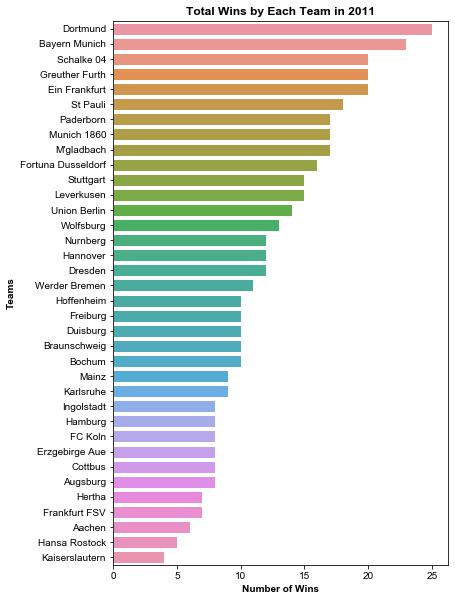

In [8]:
fig_dims = (6, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="darkgrid")
ax = sns.barplot(x="Total_Wins", y="Team", data=updated_df)
plt.ylabel('Teams', fontweight='bold')
plt.xlabel('Number of Wins', fontweight='bold')
plt.title('Total Wins by Each Team in 2011', fontweight = 'bold')
plt.savefig('Wins by Each Team.jpeg', dpi=300, bbox_inches = "tight")

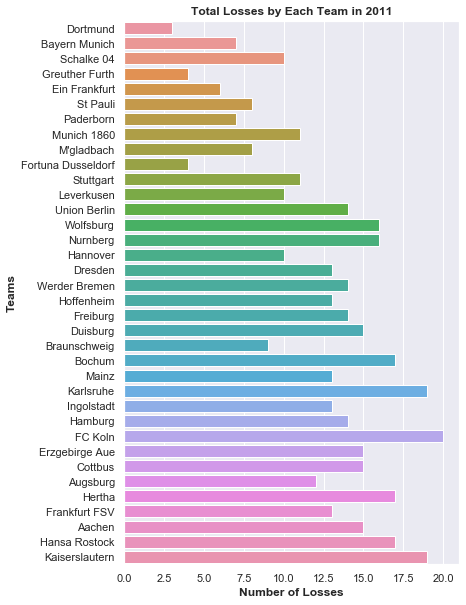

In [9]:
fig_dims = (6, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="darkgrid")
ax = sns.barplot(x="Total_Losses", y="Team", data=updated_df)
plt.ylabel('Teams', fontweight='bold')
plt.xlabel('Number of Losses', fontweight='bold')
plt.title('Total Losses by Each Team in 2011', fontweight = 'bold')
plt.savefig('Losses by Each Team.jpeg', dpi=300, bbox_inches = "tight")

## DarkSky API & Rain Statistics

As documented in DarkSky API documentation, API requests must be formatted as follows,
<code>https://api.darksky.net/forecast/[key]/[latitude],[longitude],[time]</code>

With the <code>time</code> column be formatted in "YYYY-MM-DDTHH-MM-SS"

As the date given to use were not in this format, we will modify our data by adding "T17-00-00" to every date entries in our dataset, 1700 was chosen as it is the most common kickoff time for Bundesliga in the 2011 season.

In [10]:
rain_query = '''SELECT * 
            from Matches 
            WHERE Season = 2011 AND Div != "E0"
            ORDER BY Date'''

df_query = df_setup.read_sql(rain_query)
rain_df = df_query
rain_df.Date = rain_df.Date.apply(lambda x: x + 'T17:00:00')
rain_df

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1133,D2,2011,2011-07-15T17:00:00,Cottbus,Dresden,2,1,H
1,1167,D2,2011,2011-07-15T17:00:00,Greuther Furth,Ein Frankfurt,2,3,A
2,1551,D2,2011,2011-07-15T17:00:00,Frankfurt FSV,Union Berlin,1,1,D
3,1550,D2,2011,2011-07-16T17:00:00,Erzgebirge Aue,Aachen,1,0,H
4,1678,D2,2011,2011-07-16T17:00:00,St Pauli,Ingolstadt,2,0,H
...,...,...,...,...,...,...,...,...,...
607,1528,D2,2011,2012-05-06T17:00:00,Hansa Rostock,Greuther Furth,2,2,D
608,1540,D2,2011,2012-05-06T17:00:00,Munich 1860,Aachen,1,2,A
609,1552,D2,2011,2012-05-06T17:00:00,Cottbus,Union Berlin,2,1,H
610,1610,D2,2011,2012-05-06T17:00:00,St Pauli,Paderborn,5,0,H


In [11]:
len(rain_df.Date.unique())

136

As we were only given 1000 free API calls per day, we will only request for unique date as we have 612 entries from the query above.

In [12]:
## Function to obtain secret key
def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [13]:
## Define path for secret key
keys = get_keys("/Users/songying7/Desktop/Projects/module_2_project/darksky_api.json")

api_key = keys['api_key']

Now, we are ready to request for weather information from the DarkSky API. For simplification of the assignment, we were instructed to use Berlin, Germany as our location of interest for each Bundelisga match. The coordinates for central of Berlin, Germany is given by {52.5200, 13.4050}.

In [14]:
date_weather = {}
for date in rain_df.Date.unique():
    url = f"https://api.darksky.net/forecast/{api_key}/52.5200,13.4050,{date}"
    response = requests.get(url)
    weather = response.json()['daily']['data'][0].get('icon', 0)
    date_weather.update({date: weather})

In [15]:
date_weather

{'2011-07-15T17:00:00': 'partly-cloudy-day',
 '2011-07-16T17:00:00': 0,
 '2011-07-17T17:00:00': 'rain',
 '2011-07-18T17:00:00': 'rain',
 '2011-07-22T17:00:00': 'rain',
 '2011-07-23T17:00:00': 'rain',
 '2011-07-24T17:00:00': 'partly-cloudy-day',
 '2011-07-25T17:00:00': 'partly-cloudy-day',
 '2011-08-05T17:00:00': 'rain',
 '2011-08-06T17:00:00': 'rain',
 '2011-08-07T17:00:00': 'rain',
 '2011-08-08T17:00:00': 'rain',
 '2011-08-12T17:00:00': 'rain',
 '2011-08-13T17:00:00': 'partly-cloudy-day',
 '2011-08-14T17:00:00': 'rain',
 '2011-08-15T17:00:00': 'rain',
 '2011-08-19T17:00:00': 'partly-cloudy-day',
 '2011-08-20T17:00:00': 0,
 '2011-08-21T17:00:00': 0,
 '2011-08-22T17:00:00': 'partly-cloudy-day',
 '2011-08-26T17:00:00': 0,
 '2011-08-27T17:00:00': 'partly-cloudy-day',
 '2011-08-28T17:00:00': 'partly-cloudy-day',
 '2011-08-29T17:00:00': 'partly-cloudy-day',
 '2011-09-09T17:00:00': 'partly-cloudy-day',
 '2011-09-10T17:00:00': 'partly-cloudy-day',
 '2011-09-11T17:00:00': 'rain',
 '2011-09-12T

We have successfully requested for the weather for each unique date we have, now we will map the result onto our original dataframe with the corresponding weather during the match.

In [16]:
rain_df

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1133,D2,2011,2011-07-15T17:00:00,Cottbus,Dresden,2,1,H
1,1167,D2,2011,2011-07-15T17:00:00,Greuther Furth,Ein Frankfurt,2,3,A
2,1551,D2,2011,2011-07-15T17:00:00,Frankfurt FSV,Union Berlin,1,1,D
3,1550,D2,2011,2011-07-16T17:00:00,Erzgebirge Aue,Aachen,1,0,H
4,1678,D2,2011,2011-07-16T17:00:00,St Pauli,Ingolstadt,2,0,H
...,...,...,...,...,...,...,...,...,...
607,1528,D2,2011,2012-05-06T17:00:00,Hansa Rostock,Greuther Furth,2,2,D
608,1540,D2,2011,2012-05-06T17:00:00,Munich 1860,Aachen,1,2,A
609,1552,D2,2011,2012-05-06T17:00:00,Cottbus,Union Berlin,2,1,H
610,1610,D2,2011,2012-05-06T17:00:00,St Pauli,Paderborn,5,0,H


In [17]:
# Map weather data to original dataframe on 'Date'
rain_df['Weather'] = rain_df['Date'].map(date_weather)

As we have obtained a lot of null values during our API calls, we will attempt to fill the null values by using a random weighted distribution based on the known values.

In [18]:
choice = sorted(rain_df[rain_df.Weather != 0]['Weather'].unique())
prob = rain_df[rain_df.Weather != 0]['Weather'].value_counts(normalize=True).sort_index()
rain_df['Weather'] = rain_df.Weather.map(lambda x: np.random.choice(choice, 1, p= prob)[0] if x == 0 else x)

As different weather conditions were present in the weather column, we will convert the values into boolean values, 1 for rain and 0 for no rain.

In [19]:
for weather in rain_df.Weather:
    if weather == 'rain':
        rain_df.Weather.replace(to_replace = weather, value = 1, inplace=True)
    elif weather == 'partly-cloudy-day':
        rain_df.Weather.replace(to_replace = weather, value = 0, inplace=True)
    elif weather == 'cloudy':
        rain_df.Weather.replace(to_replace = weather, value = 0, inplace=True)
    elif weather == 'wind':
        rain_df.Weather.replace(to_replace = weather, value = 0, inplace=True)
    elif weather == 'clear-day':
        rain_df.Weather.replace(to_replace = weather, value = 0, inplace=True)

In [20]:
rain_df.Weather.value_counts()

0       352
1       245
snow     15
Name: Weather, dtype: int64

We have succesfully converted the weather column into a boolean column, now we can analyze the matches played during a rainy day for our final task.

In [21]:
rain_matches = rain_df[rain_df.Weather == 1]
rain_matches

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Weather
5,1146,D2,2011,2011-07-17T17:00:00,Karlsruhe,Duisburg,3,2,H,1
6,1442,D2,2011,2011-07-17T17:00:00,Braunschweig,Munich 1860,3,1,H,1
7,1602,D2,2011,2011-07-17T17:00:00,Hansa Rostock,Paderborn,1,2,A,1
8,1360,D2,2011,2011-07-18T17:00:00,Fortuna Dusseldorf,Bochum,2,0,H,1
9,1505,D2,2011,2011-07-22T17:00:00,Duisburg,Cottbus,1,2,A,1
...,...,...,...,...,...,...,...,...,...,...
607,1528,D2,2011,2012-05-06T17:00:00,Hansa Rostock,Greuther Furth,2,2,D,1
608,1540,D2,2011,2012-05-06T17:00:00,Munich 1860,Aachen,1,2,A,1
609,1552,D2,2011,2012-05-06T17:00:00,Cottbus,Union Berlin,2,1,H,1
610,1610,D2,2011,2012-05-06T17:00:00,St Pauli,Paderborn,5,0,H,1


Similarly, each match entry consists of 2 teams, hence we must count the result separately and then add to our final count, as accomplished with the code below:

In [22]:
# Count Win/Draw/Loss
HomeWin = rain_matches.groupby('HomeTeam')['FTR'].apply(lambda x: x[x =='H'].count())
AwayWin = rain_matches.groupby('HomeTeam')['FTR'].apply(lambda x: x[x =='A'].count())
HomeDraw = rain_matches.groupby('HomeTeam')['FTR'].apply(lambda x: x[x =='D'].count())
AwayDraw = rain_matches.groupby('HomeTeam')['FTR'].apply(lambda x: x[x =='D'].count())
HomeLoss = rain_matches.groupby('HomeTeam')['FTR'].apply(lambda x: x[x =='A'].count())
AwayLoss = rain_matches.groupby('HomeTeam')['FTR'].apply(lambda x: x[x =='H'].count())

# Summarize
TotalWin = HomeWin + AwayWin
TotalDraw = HomeDraw + AwayDraw
TotalLoss = HomeLoss + AwayLoss
TotalGames = TotalWin + TotalDraw + TotalLoss
Rain_Win_Percentage = round(TotalWin * 100 / TotalGames, 2 )

# Place in a pandas dataframe
RainStats = pd.concat([TotalWin, TotalDraw, TotalLoss, TotalGames, Rain_Win_Percentage], axis = 1) 

# Define column names
RainStats.columns = ['TotalWin', 'TotalDraw', 'TotalLoss', 'TotalGames', 'Rain_Win_Percentage']

In [23]:
RainStats

,TotalWin,TotalDraw,TotalLoss,TotalGames,Rain_Win_Percentage
HomeTeam,,,,,
Aachen,1,4,1,6,16.67
Augsburg,4,6,4,14,28.57
Bayern Munich,5,0,5,10,50.00
Bochum,5,0,5,10,50.00
Braunschweig,4,8,4,16,25.00
Cottbus,3,4,3,10,30.00
Dortmund,6,0,6,12,50.00
Dresden,7,0,7,14,50.00
Duisburg,3,2,3,8,37.50


Nice ! We have created a simple summary of rain matches, we will now import the rain win percentage column to our original dataframe to have a complete table before importing to MongoDB.

In [24]:
RainStats_Short = pd.concat([Rain_Win_Percentage], axis = 1) 
RainStats_Short.columns = ['Rain_Win_Percentage']
RainStats_Short.reset_index(inplace = True)
RainStats_Short.rename(columns={"HomeTeam": "Team"}, inplace = True)
RainStats_Short

,Team,Rain_Win_Percentage
0,Aachen,16.67
1,Augsburg,28.57
2,Bayern Munich,50.00
3,Bochum,50.00
4,Braunschweig,25.00
5,Cottbus,30.00
6,Dortmund,50.00
7,Dresden,50.00
8,Duisburg,37.50
9,Ein Frankfurt,37.50


In [25]:
final_df = pd.merge(updated_df,RainStats_Short, on = "Team")

In [26]:
final_df.head()

,Team,Games_Played,Goals_Scored,Goals_Conceded,Total_Wins,Total_Draws,Total_Losses,Win_Percentage,Rain_Win_Percentage
0,Dortmund,34,80,25,25,6,3,73,50.0
1,Bayern Munich,34,77,22,23,4,7,67,50.0
2,Schalke 04,34,74,44,20,4,10,58,50.0
3,Greuther Furth,34,73,27,20,10,4,58,40.0
4,Ein Frankfurt,34,76,33,20,8,6,58,37.5


There we go, a complete table consisting of:
1. Team Name
2. Goals Scored
3. Total Wins
4. Rain Win Percentage 

We are ready to import the final dataframe to MongoDB.

We now create a new class for MongoDB to initialize a new database, along with funtions to create collections, read, update and delete from the database.

In [41]:
class MongoDB():
    def __init__(self, database_name):
        myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
        self.myclient = myclient
        self.database_name = database_name
        mydb = myclient[self.database_name]
        self.mydb = mydb
    
    def df_to_dict(self, df):
        df_dict = df.to_dict(orient = 'records')
        self.df_dict = df_dict
        return df_dict
    
    def addCollection(self, collection_name):
        mycollection = self.mydb[collection_name]
        results = mycollection.insert_many(self.df_dict)
        self.collection_name = collection_name
        self.collection = mycollection
        return mycollection
    
    def db_list(self):
        return self.myclient.list_database_names()
    
    def collection_list(self):
        return self.mydb.list_collection_names()
    
    def drop_database(self):
        self.myclient.drop_database(self.database_name)
        return '{} database dropped'.format(self.database_name)
    
    def del_collection(self):
        self.mydb.drop_collection(self.collection_name)     
        return '{} collection dropped'.format(self.collection_name)
    
    def print_records(self):
        query  = self.collection.find({})
        for record in query:
            print (record)

In [43]:
delphi_football = MongoDB('delphi_football')
delphi_football.df_to_dict(final_df)
delphi_football.addCollection('delphi_football')

Collection(Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True), 'delphi_football'), 'delphi_football')

We can try it out by querying from the MongoDB, for example we can try to find the rows associated with Dortmund below,

In [44]:
mydb

NameError: name 'mydb' is not defined

In [45]:
collection = mydb['delphi_football']
query = collection.find({'Team':'Dortmund'})
for record in query[:5]:
    print(record)

NameError: name 'mydb' is not defined

Or we can try to find the rows of team who scored exactly 20 wins during the season

In [41]:
collection = mydb['delphi_football']
query = collection.find({'Total_Wins': 20})
for record in query[:5]:
    print(record)

NameError: name 'mydb' is not defined

Great ! We have completed our project ! Thank you for reading !